# N-grams

Can we run the ngram code on the newly scraped projects, and what kind of results do we get. 

In [18]:
%load_ext autoreload
%autoreload 2

from pymongo import MongoClient

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import analysis_utilities

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci' :  True}))

print("Found {} projects with a travis build status date".format(len(projects)))

Found 685 projects with a travis build status date


In [20]:
import ngramizer
from collections import Counter

def is_bot_comment(comment):
    BOT_NAMES = ["coveralls", "codecov-io", "slnode", "pep8speaks", "rh-atomic-bot", "cesium-concierge", "azurecla", "greenkeeperio-bot", "msftclas"]
    
    return comment["user"]["login"] in BOT_NAMES


In [62]:
valid = 0

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    if len(prs_before) >= 100 and len(prs_after) >= 100:
        valid += 1
        
print(valid)

390


In [63]:
ngram_length= 2

import random

random.seed(76)

sample = random.sample(projects, 15)

def add_pre_processed_comment_to_counter(bigrams, counter):
    for bigram in bigrams:
        counter[(bigram["bigram"][0], bigram["bigram"][1])] += bigram["occurrence"]

for project in sample:    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True, seed=423)
    
    if len(prs_before) < 100 or len(prs_after) < 100:
        continue
        
    usernames = []
    
    for pr in prs_before:
        
        usernames.extend(ngramizer.given_text_extract_usernames(pr["body"]))
        
        usernames.append(pr["user"]["login"])
        
        for comment in pr["raw_comments"]:
            usernames.extend(ngramizer.given_text_extract_usernames(comment["body"]))
            usernames.append(comment["user"]["login"])
            
    for pr in prs_after:
        
        usernames.append(pr["user"]["login"])
        
        usernames.extend(ngramizer.given_text_extract_usernames(pr["body"]))
        
        for comment in pr["raw_comments"]:
            usernames.append(comment["user"]["login"])
            usernames.extend(ngramizer.given_text_extract_usernames(comment["body"]))
            
    usernames = list(set(usernames))
            
    project["usernames"] = usernames
        
    counter_pr_before = Counter()
    counter_pr_after = Counter()
    
    linkback_pr_before = {}
    linkback_pr_after = {}
    
    for pr in prs_before:
        
        if "bigrams" not in pr:
            print("Invalid pr")
            continue
        
        #if not ngramizer.is_bot_comment(pr["user"]["login"]):
        #ngramizer.add_text_ngrams_to_counter(pr["body"], pr.get("html_url", ""), ngram_length, counter_pr_before, linkback_pr_before, project["usernames"])
        
        add_pre_processed_comment_to_counter(pr["bigrams"], counter_pr_before)
        
        for comment in pr["raw_comments"]:
            
            if "bigrams" not in comment:
                print("Invalid comment")
                continue
            #if not ngramizer.is_bot_comment(comment["user"]["login"]):
            #ngramizer.add_text_ngrams_to_counter(comment["body"], comment.get("html_url", ""), ngram_length, counter_pr_before, linkback_pr_before, project["usernames"])
            
            add_pre_processed_comment_to_counter(comment["bigrams"], counter_pr_before)
            
    for pr in prs_after:
        if "bigrams" not in pr:
            print("Invalid pr")
            continue
        #if not ngramizer.is_bot_comment(pr["user"]["login"]):
        #ngramizer.add_text_ngrams_to_counter(pr["body"], pr.get("html_url", ""), ngram_length, counter_pr_after, linkback_pr_after, project["usernames"])
        
        add_pre_processed_comment_to_counter(pr["bigrams"], counter_pr_after)
        
        for comment in pr["raw_comments"]:
            
            if "bigrams" not in comment:
                print("Invalid comment")
                continue
            #if not ngramizer.is_bot_comment(comment["user"]["login"]):
            #ngramizer.add_text_ngrams_to_counter(comment["body"], comment.get("html_url", ""), ngram_length, counter_pr_after, linkback_pr_after, project["usernames"])
            
            add_pre_processed_comment_to_counter(comment["bigrams"], counter_pr_after)
                
    project["counter_pr_before"] = counter_pr_before
    project["counter_pr_after"] = counter_pr_after
    
    project["linkback_pr_before"] = linkback_pr_before
    project["linkback_pr_after"] = linkback_pr_after

In [64]:
for project in sample:
    print("{} {}".format(project["full_name"], 'counter_pr_before' in project))
    


bndtools/bnd True
nipy/dipy False
ExactTarget/fuelux False
w3c/csswg-test True
enigma-dev/enigma-dev True
Vauxoo/addons-vauxoo True
guard/guard True
praekelt/vumi-go True
celluloid/celluloid False
emberjs/data True
cloudfoundry/cloud_controller_ng False
pimcore/pimcore True
slick/slick True
cfpb/cfgov-refresh True
networkx/networkx False


In [68]:
for project in sample:
    
    if "counter_pr_before" not in project:
        continue
    
    total_before = sum(project["counter_pr_before"].values())
    
    total_after = sum(project["counter_pr_after"].values())
        
    print("{} (Before: {}, After: {})".format(project["full_name"], total_before, total_after))
    print("\tBefore:")
    
    for item in project["counter_pr_before"].most_common(10):
        print("{} - {:.0f}/{:.3f}%".format(item[0], item[1], item[1] / total_before * 100))
        
    print("\tAfter:")
    for item in project["counter_pr_after"].most_common(10):
        print("{} - {:.0f}/{:.3f}%".format(item[0], item[1], item[1] / total_after * 100))

bndtools/bnd (Before: 3659, After: 1650)
	Before:
('M_USERNAME', 'M_USERNAME') - 36/0.984%
('would', 'like') - 9/0.246%
('signed-off-bi', 'ferri') - 8/0.219%
('empti', 'directori') - 7/0.191%
('ds', 'M_VERSION_NUMBER') - 6/0.164%
('ds', 'annot') - 6/0.164%
('project', 'workspac') - 5/0.137%
('command', 'line') - 5/0.137%
('feel', 'free') - 5/0.137%
('.bnd', 'file') - 4/0.109%
	After:
('signed-off-bi', 'peter') - 8/0.485%
('signed-off-bi', 'bj') - 8/0.485%
('bndrun', 'file') - 6/0.364%
('use', 'case') - 6/0.364%
('signed-off-bi', 'neil') - 6/0.364%
('signed-off-bi', 'tim') - 5/0.303%
('gradl', 'plugin') - 4/0.242%
('jar', 'file') - 4/0.242%
('M_ICODE', 'M_ICODE') - 4/0.242%
('sub', 'command') - 4/0.242%
w3c/csswg-test (Before: 5840, After: 9650)
	Before:
('automat', 'valid') - 263/4.503%
('valid', 'check') - 253/4.332%
('check', 'commit') - 246/4.212%
('refer', 'must') - 100/1.712%
('link', 'track') - 63/1.079%
('css', 'test') - 32/0.548%
('M_USERNAME', 'M_USERNAME') - 30/0.514%
('test'

In [66]:
for project in sample:
    
    if "counter_pr_before" not in project:
        continue
    
    counter_pr_before = project["counter_pr_before"]
    counter_pr_after = project["counter_pr_after"]
    
    total_before = len(counter_pr_before.values())
    total_after = len(counter_pr_after.values())
    
    keys_before = counter_pr_before.keys()
    keys_after =  counter_pr_after.keys()
    
    for key in keys_before:
        continue
        counter_pr_before[key] = counter_pr_before[key] / total_before * 100
        
    for key in keys_after:
        continue
        counter_pr_after[key] = counter_pr_after[key] / total_after * 100
    
    delta_b_to_a = keys_before - keys_after
    delta_a_to_b = keys_after - keys_before
    
    
    b_to_a_counter = Counter()
    a_to_b_counter = Counter()
    
    for elm in delta_b_to_a:
        b_to_a_counter[elm] = counter_pr_before[elm]
        
    for elm in delta_a_to_b:
        a_to_b_counter[elm] = counter_pr_after[elm]
        
    project["counter_pr_b_to_a"] = b_to_a_counter
    project["counter_pr_a_to_b"] = a_to_b_counter

In [71]:
for project in sample:
    
    if "counter_pr_before" not in project:
        continue
    
    total_before = len(project["counter_pr_before"].values())
    total_after = len(project["counter_pr_after"].values())
    
    print("{}".format(project["full_name"], total_before, total_after))
    print("\tDisapeared:")
    
    total_before = len(project["counter_pr_before"].values())
    total_after = len(project["counter_pr_after"].values())
    
    for item in project["counter_pr_b_to_a"].most_common(10):
        print("{} - {:.0f}/{:.3f}%".format(item[0], item[1], item[1] / total_before * 100))
        
    print("\tAppeared:")
    for item in project["counter_pr_a_to_b"].most_common(10):
        print("{} - {:.0f}/{:.3f}%".format(item[0], item[1], item[1] / total_after * 100))

bndtools/bnd
	Disapeared:
('M_USERNAME', 'M_USERNAME') - 36/1.142%
('would', 'like') - 9/0.286%
('signed-off-bi', 'ferri') - 8/0.254%
('empti', 'directori') - 7/0.222%
('ds', 'M_VERSION_NUMBER') - 6/0.190%
('feel', 'free') - 5/0.159%
('project', 'workspac') - 5/0.159%
('fix', 'bndtool') - 4/0.127%
('make', 'work') - 4/0.127%
('actual', 'need') - 4/0.127%
	Appeared:
('signed-off-bi', 'bj') - 8/0.526%
('signed-off-bi', 'peter') - 8/0.526%
('signed-off-bi', 'neil') - 6/0.394%
('signed-off-bi', 'tim') - 5/0.329%
('jar', 'file') - 4/0.263%
('sub', 'command') - 4/0.263%
('M_ICODE', 'M_ICODE') - 4/0.263%
('gradl', 'plugin') - 4/0.263%
('multipl', 'jar') - 3/0.197%
('amend', 'commit') - 3/0.197%
w3c/csswg-test
	Disapeared:
('css', 'test') - 32/0.982%
('test', 'repo') - 29/0.890%
('open', 'pr') - 27/0.829%
('creat', 'previous') - 26/0.798%
('previous', 'old') - 26/0.798%
('directori', 'structur') - 26/0.798%
('recent', 'undergon') - 26/0.798%
('care', 'open') - 26/0.798%
('repo', 'recent') - 26

# Can we extract all sentences that contain the word Travis

In [63]:
%load_ext autoreload
%autoreload 2

from pymongo import MongoClient
from bson.objectid import ObjectId

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

commits_collection = database["commits"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import analysis_utilities

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci': True}))

print("Found {} projects with a travis build status date".format(len(projects)))

Found 685 projects with a travis build status date


In [65]:
import ngramizer as nz

found_mentions = []

for project in projects:
    # This is a list of all PRs which have a discussion comment that mentions travis. 
    travis_prs = list(pull_requests_collection.find(
                {
                    'raw_comments.bigrams.bigram': 'travi',
                    'project_owner': project["full_name"].split("/")[0],
                    'project_name': project["full_name"].split("/")[1]
                }))
    
    for pr in travis_prs:
        for comment in pr["raw_comments"]:
            body = comment["body"]
            
            cleaned_text = nz.remove_markdown_content(nz.tokenize_text(nz.clean_text(body)))
            
            for sentence in nz.split_into_sentences(cleaned_text):
                if "travis" in sentence.lower():
                    found_mentions.append(
                        {
                            'project': project["full_name"],
                            'prNumber': pr["number"],
                            'prUrl': pr["html_url"],
                            'commentUrl': comment["html_url"],
                            'sentence': sentence
                        })

In [66]:
import csv

with open('generated/travis_mentions.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Project", "PrNumber", "PrUrl", "CommentUrl", "Sentence"])
    
    for item in found_mentions:
        writer.writerow([item["project"], item["prNumber"], item["prUrl"], item["commentUrl"], item["sentence"]])

The below cells follow the following tutorial to create a LDA model for the travis mentions: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [67]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

import nltk
nltk.download('wordnet')

stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nathancassee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
print('original document: {}'.format([word for word in found_mentions[4235]["sentence"].split(" ")]))

print('tokenized and lemmatized document: {}'.format(preprocess(found_mentions[4235]["sentence"])))


original document: ['Ok', 'this', 'time', 'it', 'seems', 'actually', 'flaky,', 'as', 'the', 'same', 'commit', 'passed', 'in', 'a', 'different', 'travis', 'job', 'against', 'my', 'fork', '-', '', 'M_URL']
tokenized and lemmatized document: ['time', 'actual', 'flaki', 'commit', 'pass', 'differ', 'travi', 'fork', 'm_url']


In [69]:
processed_docs = [preprocess(item["sentence"]) for item in found_mentions]

print(processed_docs[:10])

[['travi', 'configur', 'ident', 'case'], ['point', 'direct', 'investig', 'travi', 'browserstack', 'config'], ['depend', 'command', 'travi', 'use', 'test', 'abl'], ['upgrad', 'node', 'version', 'travi', 'dep', 'upgrad', 'compat', 'bug'], ['test', 'skip', 'travi', 'fix', 'm_issue_ment', 'merg', 'load'], ['radic', 'chang', 'semant', 'm_icod', 'method', 'make', 'unit', 'test', 'fail', 'travi', 'integr'], ['travi', 'error', 'trail', 'space', 'easili', 'fix'], ['local', 'time', 'thing', 'travi', 'say'], ['unit', 'test', 'fail', 'check', 'travi', 'detail', 'm_icod', 'local', 'time'], ['travi', 'build', 'pass']]


In [70]:
# Create a bag of words model 

dictionary = gensim.corpora.Dictionary(processed_docs)

dictionary.filter_extremes(no_below=15, no_above=0.6, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(bow_corpus[4310])

[(40, 1), (66, 1), (103, 1), (522, 1)]


In [71]:
from gensim import corpora, models

NUM_TOPICS = 4

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.017*"build" + 0.015*"test" + 0.014*"fail" + 0.014*"pull" + 0.012*"request" + 0.011*"rebas" + 0.011*"problem" + 0.010*"version" + 0.010*"break" + 0.010*"relat"

Topic: 1 Word: 0.048*"fail" + 0.041*"build" + 0.030*"pass" + 0.030*"test" + 0.023*"m_mention" + 0.021*"restart" + 0.019*"m_icod" + 0.017*"sure" + 0.017*"m_url" + 0.013*"local"

Topic: 2 Word: 0.027*"error" + 0.026*"failur" + 0.023*"look" + 0.019*"unrel" + 0.019*"like" + 0.018*"fail" + 0.017*"build" + 0.015*"test" + 0.014*"m_mention" + 0.014*"know"

Topic: 3 Word: 0.032*"merg" + 0.028*"happi" + 0.026*"green" + 0.017*"issu" + 0.017*"build" + 0.015*"test" + 0.014*"good" + 0.013*"pass" + 0.012*"m_mention" + 0.012*"fail"



In [72]:
print(found_mentions[5732]["sentence"])

for index, score in sorted(lda_model_tfidf[bow_corpus[5732]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))
    
print()
print(found_mentions[2789]["sentence"])

for index, score in sorted(lda_model_tfidf[bow_corpus[2789]], key=lambda tup: -1*tup[1]):
    print(index)
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

merging so travis and appveyor run on it in the other pr.

Score: 0.7462731003761292	 
Topic: 0.032*"merg" + 0.028*"happi" + 0.026*"green" + 0.017*"issu" + 0.017*"build" + 0.015*"test" + 0.014*"good" + 0.013*"pass" + 0.012*"m_mention" + 0.012*"fail"

Score: 0.08525644242763519	 
Topic: 0.027*"error" + 0.026*"failur" + 0.023*"look" + 0.019*"unrel" + 0.019*"like" + 0.018*"fail" + 0.017*"build" + 0.015*"test" + 0.014*"m_mention" + 0.014*"know"

Score: 0.08453112095594406	 
Topic: 0.048*"fail" + 0.041*"build" + 0.030*"pass" + 0.030*"test" + 0.023*"m_mention" + 0.021*"restart" + 0.019*"m_icod" + 0.017*"sure" + 0.017*"m_url" + 0.013*"local"

Score: 0.08393937349319458	 
Topic: 0.017*"build" + 0.015*"test" + 0.014*"fail" + 0.014*"pull" + 0.012*"request" + 0.011*"rebas" + 0.011*"problem" + 0.010*"version" + 0.010*"break" + 0.010*"relat"

Travis CI build failed due to smoke/test_outofbandmanagement which is not connected to this code.
1

Score: 0.8689706921577454	 
Topic: 0.048*"fail" + 0.041*"

In [73]:
counts = [0 for i in range(NUM_TOPICS)]
empty = 0

clustered_items = {}

clustered_items["empty"] = []

for i in range(NUM_TOPICS):
    clustered_items[i] = []

for index, item in enumerate(bow_corpus):
    classification = sorted(lda_model_tfidf[item], key=lambda tup: -1*tup[1])
    
    if classification[0][1] > 0.5:
        counts[classification[0][0]] += 1
        clustered_items[classification[0][0]].append((found_mentions[index], classification[0][1]))
    else:
        empty += 1
        clustered_items["empty"].append(found_mentions[index])
        
print(counts)

[9420, 15948, 12472, 10029]


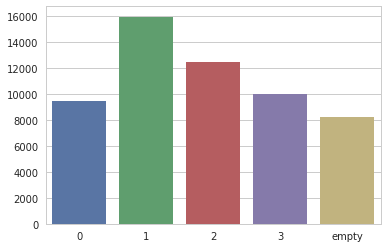

In [74]:
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.barplot(x=["0", "1", "2", "3", "empty"], y=counts+[empty])

# How about the most highly scored items per topic

In [75]:
for key in clustered_items.keys():
    sentences = clustered_items[key]
    
    print(key)
    
    if key == "empty":
        for item in sentences[:10]:
            print(item["sentence"])
            
    else:
        sorted_sents = sorted(sentences, key=lambda i : i[1], reverse = True)
        
        for item in sorted_sents[:10]:
            print("{} : {}".format(item[1], item[0]["sentence"]))
            
    print("----------")
        
        

empty
The Travis error is just a trailing space, which can be easily fixed.
The only change in the second commit was adding a space to the README.md to trigger a Travis test on my own account.
NPM is going crazy today so Travis fails, but merging still.
So no idea why the pragmas are failing to suppress the warnings specifically on TravisCI.
Unfortunately there is no useful information in the logs: It says that the shared library generation has an error, prints the actual compiler invocation arguments, but doesn't print any details of the error; the job gets aborted by TravisCI due to no terminal output after 10 minutes.
Here's the 3 failing link commands, edited to skip close to the 1600 character mark, across 3 different travisCI jobs ( M_ICODE  on Linux,  M_ICODE  on Linux,  M_ICODE  on macOS), along with the same command, truncated to the same extent, as run on my system:
For now Travis should find them but if Travis gets updated then we might need to figure out a better way to che